In [42]:
# import library
from IPython.display import Image, display
import logging
import importlib

import numpy as np
import pandas as pd
import statsmodels.api as sm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import model_to_dot

import models.gan as gan
importlib.reload(gan)

logging.basicConfig(level=logging.DEBUG)

# set seed for TensorFlow
tf.random.set_seed(20220102)

############################
# Test if GPU is available #
############################
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print(gpus)
else:
    raise Exception("No GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


INFO:jsonrpcserver.dispatcher.request:{"jsonrpc": "2.0", "method": "SyncRequest", "params": {"data": {"file_name": "/home/ling/projects/thesis/asset_pricing/gan_model.sync.py", "contents": "# %%\n# import library\nfrom IPython.display import Image, display\nimport logging\nimport importlib\n\nimport numpy as np\nimport pandas as pd\nimport statsmodels.api as sm\nimport tensorflow as tf\nimport tensorflow.keras as keras\nfrom tensorflow.keras.utils import model_to_dot\n\nimport models.gan as gan\nimportlib.reload(gan)\n\nlogging.basicConfig(level=logging.DEBUG)\n\n# set seed for TensorFlow\ntf.random.set_seed(20220102)\n\n############################\n# Test if GPU is available #\n############################\ngpus = tf.config.list_physical_devices(\"GPU\")\n\nif gpus:\n  print(gpus)\nelse:\n  raise Exception(\"No GPU\")\n\n\n# %%\n# view pydot\ndef view_pydot(pdot):\n  plt = Image(pdot.create_png())\n  display(plt)\n\n\n# %%\n# load data\npath = \"../datasets\"\n\n# training data\nmacr

In [19]:
# view pydot
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

In [20]:
# load data
path = "../datasets"

# training data
macro_train_zip = np.load(f"{path}/macro/macro_train.npz")
firm_train_zip = np.load(f"{path}/char/Char_train.npz")
macro_train = macro_train_zip["data"]
firm_train = firm_train_zip["data"]
return_train = firm_train[:, :, 0]
firm_train = firm_train[:, :, 1:]

# validation data
macro_valid_zip = np.load(f"{path}/macro/macro_valid.npz")
firm_valid_zip = np.load(f"{path}/char/Char_valid.npz")
macro_valid = macro_valid_zip["data"]
firm_valid = firm_valid_zip["data"]
return_valid = firm_valid[:, :, 0]
firm_valid = firm_valid[:, :, 1:]

# test data
macro_test_zip = np.load(f"{path}/macro/macro_test.npz")
firm_test_zip = np.load(f"{path}/char/Char_test.npz")
macro_test = macro_test_zip["data"]
firm_test = firm_test_zip["data"]
return_test = firm_test[:, :, 0]
firm_test = firm_test[:, :, 1:]

print(f"macro train shape: {macro_train.shape}")
print(f"firm train shape: {firm_train.shape}")
print(f"macro valid shape: {macro_valid.shape}")
print(f"firm valid shape: {firm_valid.shape}")
print(f"macro test shape: {macro_test.shape}")
print(f"firm test shape: {firm_test.shape}")

macro train shape: (240, 178)
firm train shape: (240, 3686, 46)
macro valid shape: (60, 178)
firm valid shape: (60, 3347, 46)
macro test shape: (300, 178)
firm test shape: (300, 7141, 46)


In [21]:
# remove zip files
del macro_train_zip, firm_train_zip
del macro_valid_zip, firm_valid_zip
del macro_test_zip, firm_test_zip

In [22]:
# Hyper-parameters (train)
_macro_feature = macro_train.shape[1]
_num_firms = firm_train.shape[1]
_num_chars = firm_train.shape[2]
macro_shape = (_macro_feature, 1, )
firm_shape = (_num_firms, _num_chars, )

print(f"macro shape: {macro_shape}")
print(f"firm shape: {firm_shape}")

macro_network = gan.create_macro_network(
    macro_shape=macro_shape,
    num_firms=_num_firms,
    name="discriminant_macro",
    LSTM_units=4
)

discriminant_network = gan.create_discriminant_network(
    firm_shape=firm_shape,
    macro_network=macro_network,
    returns=return_train
)

print(f"""network output shape: {discriminant_network(
    [macro_train, firm_train]).shape}""")
discriminant_network.summary()

generative_macro = gan.create_macro_network(
    macro_shape=macro_shape,
    num_firms=_num_firms,
    name="generative_macro",
    LSTM_units=32
)

generative_network = gan.create_generative_network(
    firm_shape=firm_shape,
    macro_network=generative_macro
)

print(f"""network output shape: {generative_network(
    [macro_train, firm_train]).shape}""")
generative_network.summary()

macro shape: (178, 1)
firm shape: (3686, 46)
network output shape: (240, 1)
Model: "discriminant_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
macro_input (InputLayer)        [(None, 178, 1)]     0                                            
__________________________________________________________________________________________________
macro_dropout (Dropout)         (None, 178, 1)       0           macro_input[0][0]                
__________________________________________________________________________________________________
macro_lstm (LSTM)               (None, 4)            96          macro_dropout[0][0]              
__________________________________________________________________________________________________
expand_dim (Lambda)             (None, 1, 4)         0           macro_lstm[0][0]                 
___

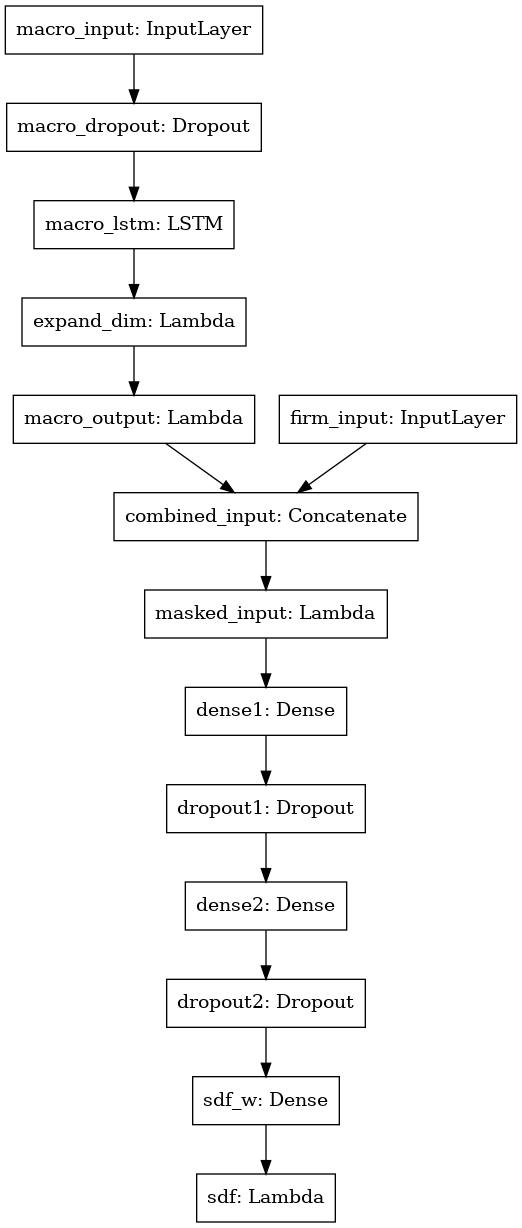

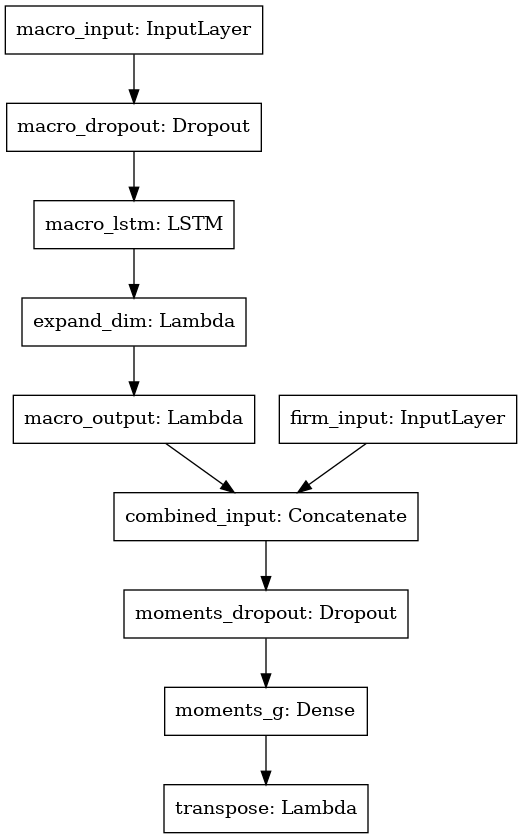

In [23]:
view_pydot(model_to_dot(discriminant_network))
view_pydot(model_to_dot(generative_network))

In [24]:
# Hyper-parameters (valid)
_macro_feature = macro_valid.shape[1]
_num_firms = firm_valid.shape[1]
_num_chars = firm_valid.shape[2]
macro_shape = (_macro_feature, 1, )
firm_shape = (_num_firms, _num_chars, )

print(f"macro shape: {macro_shape}")
print(f"firm shape: {firm_shape}")

macro_network_valid = gan.create_macro_network(
    macro_shape=macro_shape,
    num_firms=_num_firms,
    name="discriminant_macro_valid",
    LSTM_units=4
)

discriminant_network_valid = gan.create_discriminant_network(
    firm_shape=firm_shape,
    macro_network=macro_network_valid,
    returns=return_valid
)

print(f"""network output shape: {discriminant_network_valid(
    [macro_valid, firm_valid]).shape}""")
discriminant_network.summary()

macro shape: (178, 1)
firm shape: (3347, 46)
network output shape: (60, 1)
Model: "discriminant_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
macro_input (InputLayer)        [(None, 178, 1)]     0                                            
__________________________________________________________________________________________________
macro_dropout (Dropout)         (None, 178, 1)       0           macro_input[0][0]                
__________________________________________________________________________________________________
macro_lstm (LSTM)               (None, 4)            96          macro_dropout[0][0]              
__________________________________________________________________________________________________
expand_dim (Lambda)             (None, 1, 4)         0           macro_lstm[0][0]                 
____

In [25]:
# Hyper-parameters (test)
_macro_feature = macro_test.shape[1]
_num_firms = firm_test.shape[1]
_num_chars = firm_test.shape[2]
macro_shape = (_macro_feature, 1, )
firm_shape = (_num_firms, _num_chars, )

print(f"macro shape: {macro_shape}")
print(f"firm shape: {firm_shape}")

macro_network_test = gan.create_macro_network(
    macro_shape=macro_shape,
    num_firms=_num_firms,
    name="discriminant_macro_test",
    LSTM_units=4
)

discriminant_network_test = gan.create_discriminant_network(
    firm_shape=firm_shape,
    macro_network=macro_network_test,
    returns=return_test
)

print(f"""network output shape: {discriminant_network_test(
    [macro_test, firm_test]).shape}""")
discriminant_network.summary()

macro shape: (178, 1)
firm shape: (7141, 46)
network output shape: (300, 1)
Model: "discriminant_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
macro_input (InputLayer)        [(None, 178, 1)]     0                                            
__________________________________________________________________________________________________
macro_dropout (Dropout)         (None, 178, 1)       0           macro_input[0][0]                
__________________________________________________________________________________________________
macro_lstm (LSTM)               (None, 4)            96          macro_dropout[0][0]              
__________________________________________________________________________________________________
expand_dim (Lambda)             (None, 1, 4)         0           macro_lstm[0][0]                 
___

In [26]:
weight_model = keras.Model(
    inputs=discriminant_network.inputs,
    outputs=discriminant_network.get_layer("sdf_w").output
)

weight_model([macro_train, firm_train])

<tf.Tensor: shape=(336113, 1), dtype=float32, numpy=
array([[-0.05219324],
       [-0.547615  ],
       [-0.16527045],
       ...,
       [-0.4082939 ],
       [-0.25757986],
       [-0.16618699]], dtype=float32)>

In [27]:
sdf = discriminant_network([macro_train, firm_train])
moment = generative_network([macro_train, firm_train])

loss = gan.PricingLoss(
    sdf=sdf,
    moment=moment,
    returns=return_train
)

shape_loss = gan.sharpe_loss(sdf)

logging.debug(f"Initial Pricing loss: {loss}")
logging.debug(f"Initial SHARPE loss: {shape_loss}")

DEBUG:root:Initial Pricing loss: 0.06841019541025162
DEBUG:root:Initial SHARPE loss: -0.1100139170885086


In [28]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
gan.train(
    inputs=[macro_train, firm_train],
    returns=return_train,
    optimizer=optimizer,
    discriminant_network=discriminant_network,
    generative_network=generative_network,
    valid_inputs=[macro_valid, firm_valid],
    valid_returns=return_valid,
    valid_discriminant=discriminant_network_valid,
    discriminant_epochs=100,
    generative_epochs=100,
    gan_epochs=100,
    verbose_interval=10,
    min_epochs=10,
    patience=5000,
    load_weights=[True, True, True],
    save_weights=[False, False, False]
)

INFO:root:Loaded Discriminant weights


Discriminant epoch 0: Mis-Pricing (train): 0.000025; SHARPE (train): 0.255551; SHARPE (valid): 0.217807
Discriminant epoch 10: Mis-Pricing (train): 0.004519; SHARPE (train): 0.440854; SHARPE (valid): 0.363989
Discriminant epoch 20: Mis-Pricing (train): 0.001251; SHARPE (train): 0.457917; SHARPE (valid): 0.374471
Discriminant epoch 30: Mis-Pricing (train): 0.000024; SHARPE (train): 0.667023; SHARPE (valid): 0.521892
Discriminant epoch 40: Mis-Pricing (train): 0.000095; SHARPE (train): 0.874889; SHARPE (valid): 0.579007
Discriminant epoch 50: Mis-Pricing (train): 0.000107; SHARPE (train): 0.922851; SHARPE (valid): 0.574718
Discriminant epoch 60: Mis-Pricing (train): 0.000065; SHARPE (train): 0.929456; SHARPE (valid): 0.574506
Discriminant epoch 70: Mis-Pricing (train): 0.000041; SHARPE (train): 0.878004; SHARPE (valid): 0.587902
Discriminant epoch 80: Mis-Pricing (train): 0.000034; SHARPE (train): 0.869192; SHARPE (valid): 0.593319
Discriminant epoch 90: Mis-Pricing (train): 0.000033; SH

INFO:root:Loaded Generative weights


Generative epoch 0: Mis-Pricing (train): 1.496927; 
Generative epoch 10: Mis-Pricing (train): 1.527503; 
Generative epoch 20: Mis-Pricing (train): 1.562276; 
Generative epoch 30: Mis-Pricing (train): 1.594481; 
Generative epoch 40: Mis-Pricing (train): 1.629458; 
Generative epoch 50: Mis-Pricing (train): 1.659799; 
Generative epoch 60: Mis-Pricing (train): 1.690860; 
Generative epoch 70: Mis-Pricing (train): 1.720501; 
Generative epoch 80: Mis-Pricing (train): 1.747656; 
Generative epoch 90: Mis-Pricing (train): 1.774808; 


INFO:root:Loaded Discriminant GAN weights
INFO:root:Loaded Generative GAN weights


Generative epoch 100: Mis-Pricing (train): 1.798559; 
Total Generative training epochs 100
GAN epoch 0: Mis-Pricing (train): 0.011009; SHARPE (train): 1.022647; SHARPE (valid): 0.534149
GAN epoch 10: Mis-Pricing (train): 0.252074; SHARPE (train): 1.214609; SHARPE (valid): 0.901521
GAN epoch 20: Mis-Pricing (train): 0.118209; SHARPE (train): 1.464901; SHARPE (valid): 1.054854
GAN epoch 30: Mis-Pricing (train): 0.035615; SHARPE (train): 1.896691; SHARPE (valid): 1.229786
GAN epoch 40: Mis-Pricing (train): 0.039885; SHARPE (train): 2.165524; SHARPE (valid): 1.238718
GAN epoch 50: Mis-Pricing (train): 0.036695; SHARPE (train): 2.242541; SHARPE (valid): 1.187765
GAN epoch 60: Mis-Pricing (train): 0.030532; SHARPE (train): 2.205806; SHARPE (valid): 1.169000
GAN epoch 70: Mis-Pricing (train): 0.024567; SHARPE (train): 2.195568; SHARPE (valid): 1.165536
GAN epoch 80: Mis-Pricing (train): 0.021473; SHARPE (train): 2.207322; SHARPE (valid): 1.168022
GAN epoch 90: Mis-Pricing (train): 0.019051; S

In [29]:
# Loss for train
sdf_train = discriminant_network([macro_train, firm_train])

sharpe_loss_train = gan.sharpe_loss(sdf_train)

logging.debug(f"GAN Trained train SHARPE loss: {sharpe_loss_train}")

DEBUG:root:GAN Trained train SHARPE loss: 2.233700752258301


In [30]:
# Loss for valid
sdf_valid = discriminant_network_valid([macro_valid, firm_valid])

sharpe_loss_valid = gan.sharpe_loss(sdf_valid)

logging.debug(f"GAN Trained valid SHARPE loss: {sharpe_loss_valid}")

DEBUG:root:GAN Trained valid SHARPE loss: 1.1953423023223877


In [31]:
# Loss for test
discriminant_network_test.set_weights(
    discriminant_network.get_weights()
)

sdf_test = discriminant_network_test([macro_test, firm_test])

sharpe_loss_test = gan.sharpe_loss(sdf_test)

logging.debug(f"GAN Trained test SHARPE loss: {sharpe_loss_test}")

DEBUG:root:GAN Trained test SHARPE loss: 0.5893049240112305


In [32]:
# compute beta
y = firm_valid[:, 53, 0]
mask = y != -99.99
X = discriminant_network_valid([macro_valid, firm_valid]).numpy()
y = y[mask]
X = np.squeeze(X[mask])
X = sm.add_constant(X)

y.shape, X.shape

((8,), (8, 2))

In [33]:
results = sm.OLS(y, X).fit()
results.summary()

/home/ling/miniconda3/envs/ap_tf2/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.117
Method:                 Least Squares   F-statistic:                    0.2692
Date:                Wed, 12 Jan 2022   Prob (F-statistic):              0.622
Time:                        10:12:50   Log-Likelihood:                 12.533
No. Observations:                   8   AIC:                            -21.07
Df Residuals:                       6   BIC:                            -20.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4075      0.027     15.117      0.000       0.342       0.473
x1             0.0183      0.035      0.519      0.622      -0.068       0.105
==============================================================================
Omnibus:                        2.939   Durbin-Watson:                   0.924
Prob(Omnibus):                  0.230   Jarque-Bera (JB):                1.580
Skew:                          -1.031   Prob(JB):                        0.454
Kurtosis:                       2.299   Cond. No.                         2.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
X = discriminant_network([macro_train, firm_train]).numpy()
X = np.squeeze(X)
X = sm.add_constant(X)
all_results = []
for index in range(firm_train.shape[1]):
    y = firm_train[:, index, 0]
    mask = y != -99.99
    result = sm.OLS(y[mask], sm.add_constant(X[mask])).fit()
    all_results.append(result.params)
np.mean(list(map(lambda x: x[0], all_results)))

0.005679303767881673

INFO:jsonrpcserver.dispatcher.request:{"jsonrpc": "2.0", "method": "SyncRequest", "params": {"data": {"file_name": "/home/ling/projects/thesis/asset_pricing/gan_model.sync.py", "contents": "# %%\n# import library\nfrom IPython.display import Image, display\nimport logging\nimport importlib\n\nimport numpy as np\nimport statsmodels.api as sm\nimport tensorflow as tf\nimport tensorflow.keras as keras\nfrom tensorflow.keras.utils import model_to_dot\n\nimport models.gan as gan\nimportlib.reload(gan)\n\nlogging.basicConfig(level=logging.DEBUG)\n\n# set seed for TensorFlow\ntf.random.set_seed(20220102)\n\n############################\n# Test if GPU is available #\n############################\ngpus = tf.config.list_physical_devices(\"GPU\")\n\nif gpus:\n  print(gpus)\nelse:\n  raise Exception(\"No GPU\")\n\n\n# %%\n# view pydot\ndef view_pydot(pdot):\n  plt = Image(pdot.create_png())\n  display(plt)\n\n\n# %%\n# load data\npath = \"../datasets\"\n\n# training data\nmacro_train_zip = np.load

In [43]:
# check if the weights are within (0, 1)
sdf_weights = keras.Model(
    discriminant_network.inputs,
    discriminant_network.get_layer("sdf_w").output
)
weights = sdf_weights([macro_train, firm_train]).numpy()

pd.DataFrame(weights).describe()

,0
count,336113.000000
mean,0.002631
std,0.037540
min,-0.294893
25%,-0.013354
50%,0.006031
75%,0.022864
max,0.336885
